In [44]:
import numpy as np
import pandas as pd
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [45]:
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category'}

online = pd.read_csv('./DATA/온라인 행동 정보(CKS).csv', dtype=cks_dtype)
trade = pd.read_csv('./DATA/거래 정보(CKS).csv', dtype=cks_dtype)
customer = pd.read_csv('./DATA/고객 정보(CKS).csv', dtype=cks_dtype)
item = pd.read_csv('./DATA/item_add_nm0.csv', dtype=cks_dtype)

### Item 파일을 대대분류 기준으로 One-Hot 인코딩

In [53]:
# dummies = pd.get_dummies(labels, prefix='CLAC0')
# item = pd.concat([item, dummies], axis=1)
# item.drop("clac_nm0", axis=1, inplace=True)
# item.head()

In [54]:
# trade.drop('clnt_id', axis=1, inplace=True)
# test.drop(['clnt_id', 'sess_id', 'hit_seq'], axis=1, inplace=True)



## 간단한 Item EDA

In [46]:
item = item[['pd_c','clac_nm0']]

In [47]:
labels, uniques = pd.factorize(item['clac_nm0'],sort=True)
print(uniques)

Index(['Baby', 'Beauty', 'Electronic', 'Fashion', 'Food', 'Furniture',
       'Kitchen / Life', 'Others', 'Sport', 'Travel'],
      dtype='object')


In [48]:
temp = pd.merge(online, 
                trade.drop(['clnt_id','biz_unit'],axis=1)
                , on='trans_id', how='left')
temp1 = pd.merge(temp, 
                 customer, 
                 on='clnt_id', how='left')
test = pd.merge(temp1[temp1['pd_c'].notna()], 
                item, 
                on='pd_c', how='left')

In [64]:
test['clnt_age'] = test['clnt_age'].astype(str)
test['gen_age'] = test['clnt_gender'].str.cat(test['clnt_age'],sep="_")
test.drop(['clnt_gender', 'clnt_age'], axis=1, inplace=True)
test.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,trfc_src,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm0,gen_age
0,2,1,37,6,A03,20190728,23:47,791905,62037.0,NaN,...,DIRECT,unknown,1.0,92.0,20190729,23:47,36000.0,20.0,Food,F_30.0
1,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,DIRECT,unknown,1.0,186.0,20190731,21:25,3790.0,1.0,Food,F_30.0
2,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,DIRECT,unknown,2.0,151.0,20190731,21:25,3990.0,1.0,Food,F_30.0
3,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,DIRECT,unknown,3.0,351.0,20190731,21:25,4690.0,1.0,Food,F_30.0
4,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,DIRECT,unknown,4.0,189.0,20190731,21:25,4290.0,1.0,Food,F_30.0


<br><br>
### 총 구매량 시각화
다음 그림은 Online 데이터에서 대대분류 구매를 보여주는 그래프입니다.  
아래 그림과 같이 Food에 쏠림 현상이 있습니다. 

<AxesSubplot:xlabel='clac_nm0', ylabel='count'>

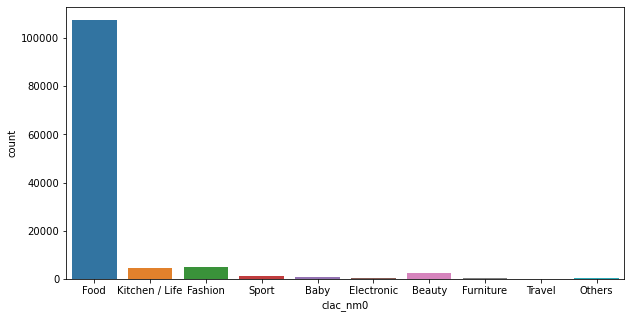

In [50]:
plt.figure(figsize=(10,5))
orders = ['Food', 'Kitchen / Life', 'Fashion', 'Sport', 'Baby', 'Electronic','Beauty', 'Furniture', 'Travel', 'Others']

sns.countplot(x = test['clac_nm0'], order=orders)

In [51]:
test

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm0
0,2,1,37,6,A03,20190728,23:47,791905,62037.0,NaN,...,unknown,1.0,92.0,20190729,23:47,36000.0,20.0,F,30.0,Food
1,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,unknown,1.0,186.0,20190731,21:25,3790.0,1.0,F,30.0,Food
2,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,unknown,2.0,151.0,20190731,21:25,3990.0,1.0,F,30.0,Food
3,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,unknown,3.0,351.0,20190731,21:25,4690.0,1.0,F,30.0,Food
4,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,...,unknown,4.0,189.0,20190731,21:25,4290.0,1.0,F,30.0,Food
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123090,72400,7,8,6,A02,20190731,09:46,103042,65027.0,NaN,...,mobile_app,1.0,1064.0,20190731,09:46,78900.0,1.0,F,40.0,Beauty
123091,72410,3,8,6,A02,20190726,13:59,437775,60926.0,NaN,...,PC,1.0,350.0,20190726,13:59,14470.0,1.0,F,40.0,Food
123092,72423,1,1,6,A01,20190917,11:48,116283,102596.0,NaN,...,mobile_app,1.0,169.0,20190917,11:48,479700.0,1.0,F,30.0,Electronic
123093,72424,2,52,6,A03,20190924,17:12,2410463,108506.0,NaN,...,PC,1.0,968.0,20190924,17:12,14900.0,2.0,M,40.0,Food


<br><br>
### 원인 분석 - 매장별 시각화
Food에 쏠리는 현상을 분석해 보니,  
A03 매장에서 Food에 구매 데이터가 쏠려 있었습니다.

Text(0.5, 1.0, 'A03 clac_nm0')

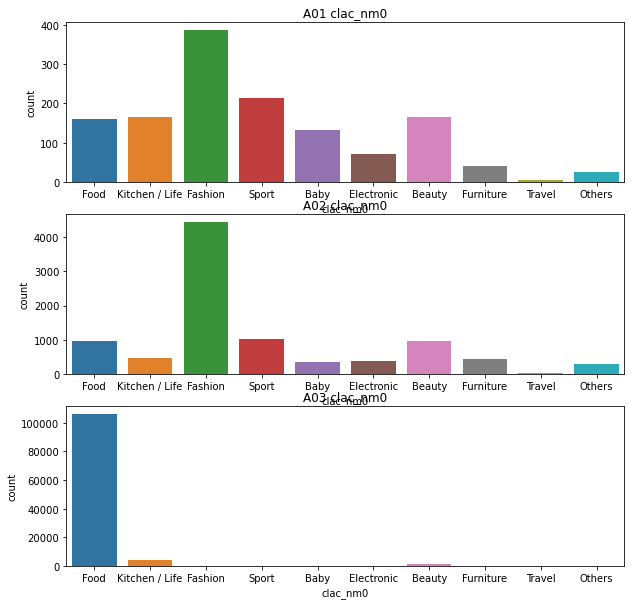

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
orders = ['Food', 'Kitchen / Life', 'Fashion', 'Sport', 'Baby', 'Electronic','Beauty', 'Furniture', 'Travel', 'Others']

sns.countplot(x=test[test['biz_unit']=='A01']['clac_nm0'], order=orders,ax=axs[0]).set_title('A01 clac_nm0')
sns.countplot(x=test[test['biz_unit']=='A02']['clac_nm0'], order=orders, ax=axs[1]).set_title('A02 clac_nm0')
sns.countplot(x=test[test['biz_unit']=='A03']['clac_nm0'], order=orders, ax=axs[2]).set_title('A03 clac_nm0')

### 원인 분석 - 대대분류별 시각화¶
Food에 쏠림 현상이 발생하면 모든 선호도가 Food에 초점이 맞춰질 것입니다.  
그래서 역으로 각 대대분류 별로 선호도가 어떻게 다른지 분석해보기로 했습니다.  
분석의 목표는 상품별로 선호도가 얼마나 다른 지 보기 위함입니다.  
<br> 

이번에는 간단하게 고객 유형, 사용장비 유형을 분석했습니다. 

In [67]:
CLAC0_0_test = test[test['clac_nm0']=='Food']   
CLAC0_1_test = test[test['clac_nm0']=='Fashion']      
CLAC0_2_test = test[test['clac_nm0']=='Kitchen / Life']
CLAC0_3_test = test[test['clac_nm0']=='Beauty']
CLAC0_4_test = test[test['clac_nm0']=='Sport']
CLAC0_5_test = test[test['clac_nm0']=='Baby']
CLAC0_6_test = test[test['clac_nm0']=='Furniture']
CLAC0_7_test = test[test['clac_nm0']=='Electronic']
CLAC0_8_test = test[test['clac_nm0']=='Others']
CLAC0_9_test = test[test['clac_nm0']=='Travel']

<br>  

#### 대대분류별 고객 유형

Text(0.5, 1.0, 'Travel')

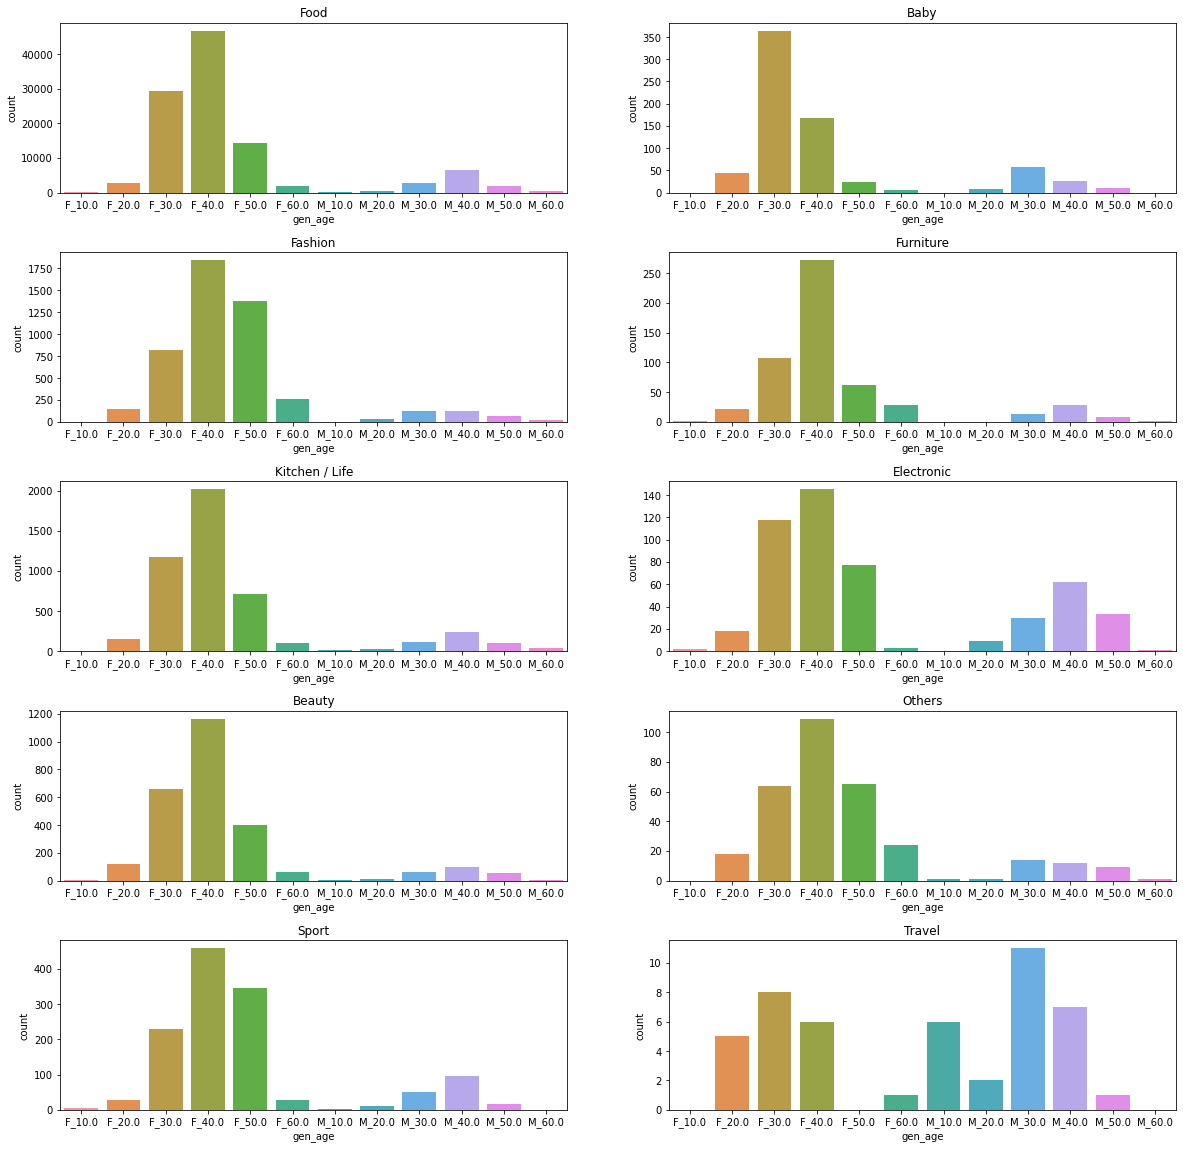

In [84]:
fig, axs = plt.subplots(5, 2, figsize=(20,20))
plt.subplots_adjust(hspace=0.35)

gorders = ['F_40.0', 'F_30.0', 'F_50.0', 'M_40.0', 'F_20.0', 'M_30.0', 'F_60.0',
       'M_50.0', 'M_60.0', 'M_20.0', 'M_10.0', 'F_10.0']
gorders.sort()

sns.countplot(x=CLAC0_0_test['gen_age'],order=gorders, ax=axs[0,0]).set_title('Food')
sns.countplot(x=CLAC0_1_test['gen_age'],order=gorders, ax=axs[1,0]).set_title('Fashion')
sns.countplot(x=CLAC0_2_test['gen_age'],order=gorders, ax=axs[2,0]).set_title('Kitchen / Life')
sns.countplot(x=CLAC0_3_test['gen_age'],order=gorders, ax=axs[3,0]).set_title('Beauty')
sns.countplot(x=CLAC0_4_test['gen_age'],order=gorders, ax=axs[4,0]).set_title('Sport')
sns.countplot(x=CLAC0_5_test['gen_age'],order=gorders, ax=axs[0,1]).set_title('Baby')
sns.countplot(x=CLAC0_6_test['gen_age'],order=gorders, ax=axs[1,1]).set_title('Furniture')
sns.countplot(x=CLAC0_7_test['gen_age'],order=gorders, ax=axs[2,1]).set_title('Electronic')
sns.countplot(x=CLAC0_8_test['gen_age'],order=gorders, ax=axs[3,1]).set_title('Others')
sns.countplot(x=CLAC0_9_test['gen_age'],order=gorders, ax=axs[4,1]).set_title('Travel')

Text(0.5, 1.0, 'Travel')

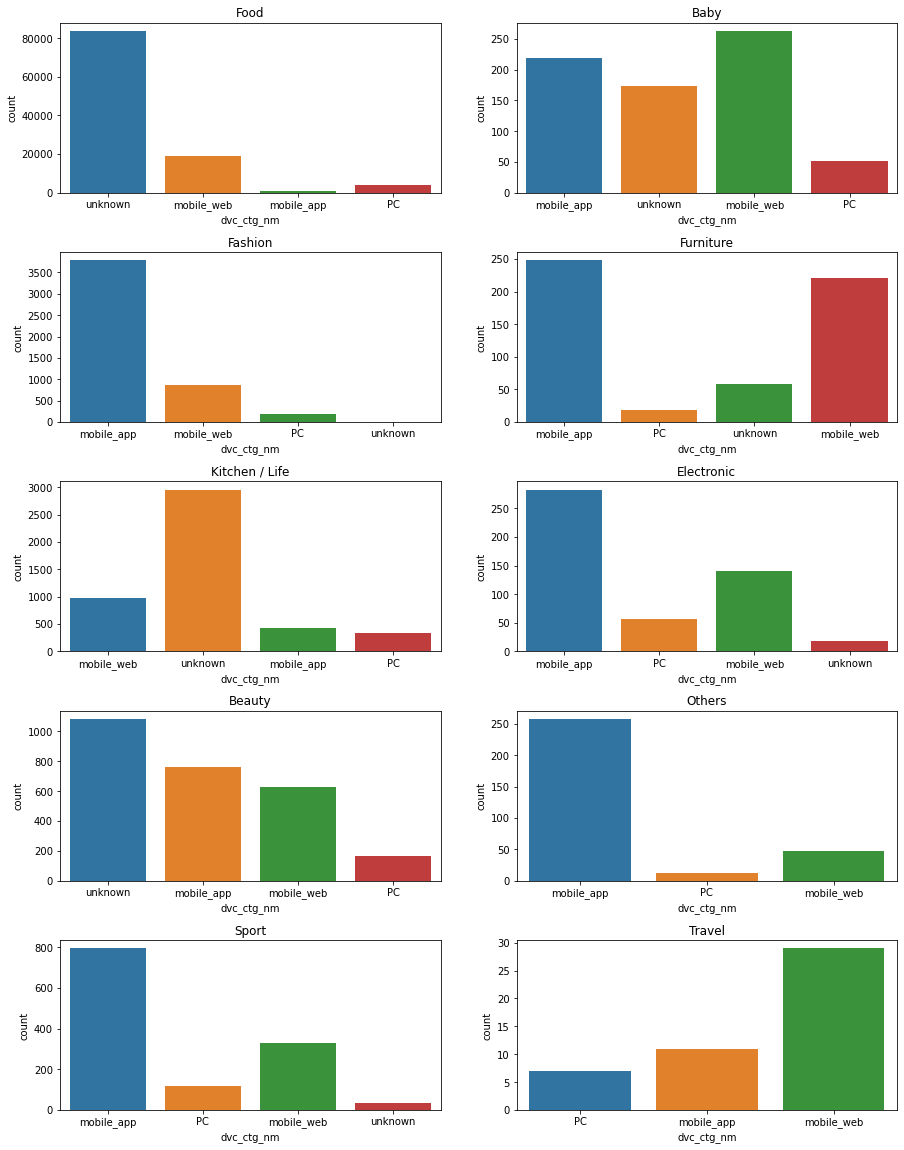

In [85]:
fig, axs = plt.subplots(5, 2, figsize=(15,20))
plt.subplots_adjust(hspace=0.35)

sns.countplot(x=CLAC0_0_test['dvc_ctg_nm'], ax=axs[0,0]).set_title('Food')
sns.countplot(x=CLAC0_1_test['dvc_ctg_nm'], ax=axs[1,0]).set_title('Fashion')
sns.countplot(x=CLAC0_2_test['dvc_ctg_nm'], ax=axs[2,0]).set_title('Kitchen / Life')
sns.countplot(x=CLAC0_3_test['dvc_ctg_nm'], ax=axs[3,0]).set_title('Beauty')
sns.countplot(x=CLAC0_4_test['dvc_ctg_nm'], ax=axs[4,0]).set_title('Sport')
sns.countplot(x=CLAC0_5_test['dvc_ctg_nm'], ax=axs[0,1]).set_title('Baby')
sns.countplot(x=CLAC0_6_test['dvc_ctg_nm'], ax=axs[1,1]).set_title('Furniture')
sns.countplot(x=CLAC0_7_test['dvc_ctg_nm'], ax=axs[2,1]).set_title('Electronic')
sns.countplot(x=CLAC0_8_test['dvc_ctg_nm'], ax=axs[3,1]).set_title('Others')
sns.countplot(x=CLAC0_9_test['dvc_ctg_nm'], ax=axs[4,1]).set_title('Travel')

In [289]:
test['clnt_age'] = test['clnt_age'].astype(str)
test['gen_age'] = test['clnt_gender'].str.cat(test['clnt_age'],sep="_")
test.drop(['clnt_gender', 'clnt_age'], axis=1, inplace=True)
test.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,CLAC0_1,CLAC0_2,CLAC0_3,CLAC0_4,CLAC0_5,CLAC0_6,CLAC0_7,CLAC0_8,CLAC0_9,gen_age
0,23,6,1,6,A01,20190720,00:37,167149,55760.0,NaN,...,0,0,0,0,0,0,0,0,0,F_40.0
1,40,28,18,6,A01,20190828,11:21,1825162,86943.0,NaN,...,0,0,0,0,1,0,0,0,0,F_30.0
2,40,28,18,6,A01,20190828,11:21,1825162,86943.0,NaN,...,0,0,0,0,1,0,0,0,0,F_30.0
3,40,33,1,6,A01,20190901,02:18,318321,89758.0,NaN,...,0,0,1,0,0,0,0,0,0,F_30.0
4,40,37,2,6,A01,20190904,10:04,494537,92593.0,NaN,...,0,0,1,0,0,0,0,0,0,F_30.0


In [290]:
test.drop(['clnt_id', 'trans_id', 'trans_seq', 'de_dt', 'de_tm','sess_dt','hit_tm','sech_kwd'], axis=1, inplace=True)

In [291]:
test

,sess_id,hit_seq,action_type,biz_unit,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,pd_c,...,CLAC0_1,CLAC0_2,CLAC0_3,CLAC0_4,CLAC0_5,CLAC0_6,CLAC0_7,CLAC0_8,CLAC0_9,gen_age
0,6,1,6,A01,167149,107.0,784.0,unknown,mobile_app,838.0,...,0,0,0,0,0,0,0,0,0,F_40.0
1,28,18,6,A01,1825162,235.0,1832.0,unknown,mobile_app,89.0,...,0,0,0,0,1,0,0,0,0,F_30.0
2,28,18,6,A01,1825162,235.0,1832.0,unknown,mobile_app,89.0,...,0,0,0,0,1,0,0,0,0,F_30.0
3,33,1,6,A01,318321,27.0,432.0,unknown,mobile_app,1663.0,...,0,0,1,0,0,0,0,0,0,F_30.0
4,37,2,6,A01,494537,150.0,548.0,unknown,mobile_app,1652.0,...,0,0,1,0,0,0,0,0,0,F_30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765,4,12,6,A02,1183974,29.0,1191.0,unknown,mobile_app,1017.0,...,0,0,0,0,0,0,1,0,0,F_40.0
10766,5,1,6,A02,14509,26.0,314.0,unknown,mobile_app,1017.0,...,0,0,0,0,0,0,1,0,0,F_40.0
10767,7,8,6,A02,103042,9.0,103.0,unknown,mobile_app,1064.0,...,1,0,0,0,0,0,0,0,0,F_40.0
10768,3,8,6,A02,437775,19.0,961.0,unknown,PC,350.0,...,0,0,0,1,0,0,0,0,0,F_40.0


In [292]:
categorical_features = ['biz_unit', 'dvc_ctg_nm', 'trfc_src']
prefix_name = ["BIZ","DVC","TRFC"]

for i in range(3):
    dummies = pd.get_dummies(test[categorical_features[i]], prefix=prefix_name[i])
    test = pd.concat([test, dummies], axis=1)
    test.drop(categorical_features[i], axis=1, inplace=True)
test.head()

,sess_id,hit_seq,action_type,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,pd_c,buy_am,buy_ct,CLAC0_0,...,DVC_PC,DVC_mobile_app,DVC_mobile_web,TRFC_DIRECT,TRFC_PORTAL_1,TRFC_PORTAL_2,TRFC_PORTAL_3,TRFC_PUSH,TRFC_WEBSITE,TRFC_unknown
0,6,1,6,167149,107.0,784.0,838.0,27000.0,1.0,1,...,0,1,0,0,0,0,0,0,0,1
1,28,18,6,1825162,235.0,1832.0,89.0,33000.0,1.0,0,...,0,1,0,0,0,0,0,0,0,1
2,28,18,6,1825162,235.0,1832.0,89.0,33000.0,1.0,0,...,0,1,0,0,0,0,0,0,0,1
3,33,1,6,318321,27.0,432.0,1663.0,97500.0,1.0,0,...,0,1,0,0,0,0,0,0,0,1
4,37,2,6,494537,150.0,548.0,1652.0,279000.0,1.0,0,...,0,1,0,0,0,0,0,0,0,1


## 30대 남자 Cluster

In [293]:
cluster = test.copy()
man_cluster = cluster.loc[cluster['gen_age'] == 'M_30.0']
man_cluster.shape

(378, 33)

In [294]:
female_cluster = cluster.loc[cluster['gen_age'] == 'F_30.0']
man_cluster.shape

(378, 33)

In [295]:
CLAC0_data.columns

Index(['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5',
       'CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9', 'furniture_new', 'baby_new',
       'beauty_new', 'electronic_new', 'fashion_new', 'food_new',
       'kitchen_new', 'others_new', 'sport_new', 'travel_new'],
      dtype='object')

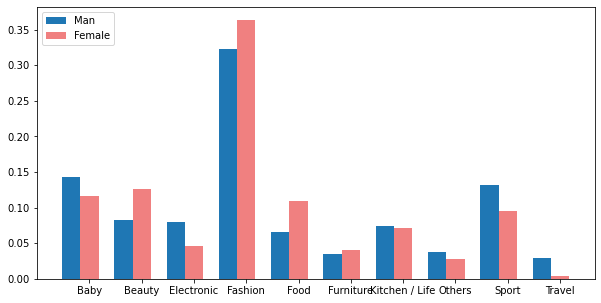

In [296]:
n_groups = 10
sum1 = man_cluster[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
sum2 = female_cluster[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
man_cnt = sum1/sum1.sum()
female_cnt = sum2/sum2.sum()
 
# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(index, man_cnt, bar_width, alpha=opacity, label='Man')
rects2 = plt.bar(index + bar_width, female_cnt, bar_width, color='lightcoral', label='Female')
 
plt.xticks(index + bar_width, uniques)
plt.legend(loc="upper left")
plt.show()

In [297]:
man_cluster.drop(['pd_c','gen_age'], axis=1, inplace=True)
man_cluster.head()

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,sess_id,hit_seq,action_type,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,buy_am,buy_ct,CLAC0_0,CLAC0_1,...,DVC_PC,DVC_mobile_app,DVC_mobile_web,TRFC_DIRECT,TRFC_PORTAL_1,TRFC_PORTAL_2,TRFC_PORTAL_3,TRFC_PUSH,TRFC_WEBSITE,TRFC_unknown
89,16,7,6,155904,11.0,265.0,47880.0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1
90,16,7,6,155904,11.0,265.0,47880.0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1
91,23,4,6,470994,24.0,703.0,1059300.0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1
92,33,1,7,34263,5.0,115.0,141500.0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1
93,33,2,7,38186,5.0,115.0,141500.0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [298]:
man_cluster.drop(['sess_id', 'hit_seq'], axis=1, inplace=True)
man_cluster.head()

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,action_type,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,buy_am,buy_ct,CLAC0_0,CLAC0_1,CLAC0_2,CLAC0_3,...,DVC_PC,DVC_mobile_app,DVC_mobile_web,TRFC_DIRECT,TRFC_PORTAL_1,TRFC_PORTAL_2,TRFC_PORTAL_3,TRFC_PUSH,TRFC_WEBSITE,TRFC_unknown
89,6,155904,11.0,265.0,47880.0,1.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
90,6,155904,11.0,265.0,47880.0,1.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
91,6,470994,24.0,703.0,1059300.0,1.0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
92,7,34263,5.0,115.0,141500.0,1.0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
93,7,38186,5.0,115.0,141500.0,1.0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [299]:
CLAC0_data = man_cluster.loc[:, man_cluster.columns.str.startswith('CLNT') | man_cluster.columns.str.startswith('CLAC0') ]
CLAC0_data.head()

,CLAC0_0,CLAC0_1,CLAC0_2,CLAC0_3,CLAC0_4,CLAC0_5,CLAC0_6,CLAC0_7,CLAC0_8,CLAC0_9
89,0,0,0,0,0,0,1,0,0,0
90,0,0,0,0,0,0,1,0,0,0
91,0,0,1,0,0,0,0,0,0,0
92,0,0,0,1,0,0,0,0,0,0
93,0,0,0,1,0,0,0,0,0,0


In [300]:
CLAC0_data.to_csv('CLAC0_data_M30.csv',index=False)

In [301]:
man_cluster.columns

Index(['action_type', 'hit_pss_tm', 'tot_pag_view_ct', 'tot_sess_hr_v',
       'buy_am', 'buy_ct', 'CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3',
       'CLAC0_4', 'CLAC0_5', 'CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9',
       'BIZ_A01', 'BIZ_A02', 'BIZ_A03', 'DVC_PC', 'DVC_mobile_app',
       'DVC_mobile_web', 'TRFC_DIRECT', 'TRFC_PORTAL_1', 'TRFC_PORTAL_2',
       'TRFC_PORTAL_3', 'TRFC_PUSH', 'TRFC_WEBSITE', 'TRFC_unknown'],
      dtype='object')

In [302]:
cluster_drop = man_cluster.drop(man_cluster.loc[:, man_cluster.columns.str.startswith('CLAC0')], axis = 1)
print(cluster_drop.shape)
cluster_drop.head()

(378, 19)


,action_type,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,buy_am,buy_ct,BIZ_A01,BIZ_A02,BIZ_A03,DVC_PC,DVC_mobile_app,DVC_mobile_web,TRFC_DIRECT,TRFC_PORTAL_1,TRFC_PORTAL_2,TRFC_PORTAL_3,TRFC_PUSH,TRFC_WEBSITE,TRFC_unknown
89,6,155904,11.0,265.0,47880.0,1.0,0,1,0,0,1,0,0,0,0,0,0,0,1
90,6,155904,11.0,265.0,47880.0,1.0,0,1,0,0,1,0,0,0,0,0,0,0,1
91,6,470994,24.0,703.0,1059300.0,1.0,0,1,0,0,1,0,0,0,0,0,0,0,1
92,7,34263,5.0,115.0,141500.0,1.0,0,1,0,0,1,0,0,0,0,0,0,0,1
93,7,38186,5.0,115.0,141500.0,1.0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [303]:
mms = MinMaxScaler()
mms.fit(cluster_drop) #대대분류 뺀 column들만 갖고
cluster_transformed = mms.transform(cluster_drop)

## Choosing the Number of Clusters : Elbow Method

In [304]:
SSD = []

for k in range(1,10):
    km = KMeans(n_clusters = k)
    km = km.fit(cluster_transformed)
    SSD.append(km.inertia_)

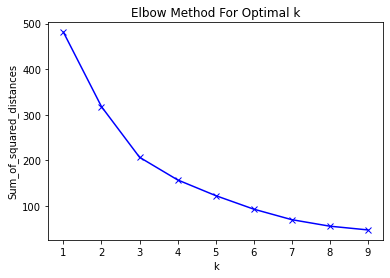

In [305]:
plt.plot(range(1,10), SSD, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [306]:
k=3
km = KMeans(n_clusters = k, algorithm = 'auto')
km.fit(cluster_transformed) # 데이터를 이용하여 클러스터링을 위한 학습 시작하고 중심점 추출

cluster_transformed = pd.DataFrame(cluster_transformed)
cluster_transformed.columns = cluster_drop.columns
cluster_transformed.index = cluster_drop.index
cluster_transformed['predict'] = km.predict(cluster_transformed)
cluster_transformed.head()

,action_type,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,buy_am,buy_ct,BIZ_A01,BIZ_A02,BIZ_A03,DVC_PC,DVC_mobile_app,DVC_mobile_web,TRFC_DIRECT,TRFC_PORTAL_1,TRFC_PORTAL_2,TRFC_PORTAL_3,TRFC_PUSH,TRFC_WEBSITE,TRFC_unknown,predict
89,0.0,0.038550,0.049505,0.063035,0.031898,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
90,0.0,0.038550,0.049505,0.063035,0.031898,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
91,0.0,0.116460,0.113861,0.167222,0.707123,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
92,1.0,0.008472,0.019802,0.027355,0.094399,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
93,1.0,0.009442,0.019802,0.027355,0.094399,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [307]:
km.cluster_centers_.shape

(3, 19)

In [308]:
cluster_transformed['predict'].value_counts()

0    146
1    140
2     92
Name: predict, dtype: int64

In [309]:
# predict clustering 0
idx = np.where(cluster_transformed['predict'] == 0)
cluster_0 = cluster.loc[cluster.index[idx]]

# predict clustering 1
idx = np.where(cluster_transformed['predict'] == 1)
cluster_1 = cluster.loc[cluster.index[idx]]

# predict clustering 2
idx = np.where(cluster_transformed['predict'] == 2)
cluster_2 = cluster.loc[cluster.index[idx]]

In [310]:
pd.DataFrame({"cluster0":round(cluster_0.mean(),2),"cluster1":round(cluster_1.mean(),2),"cluster2":round(cluster_2.mean(),2)})

,cluster0,cluster1,cluster2
sess_id,15.92,14.89,29.13
hit_seq,6.84,6.11,6.75
action_type,6.13,6.20,6.17
hit_pss_tm,750262.46,675012.33,885861.40
tot_pag_view_ct,63.29,48.14,52.63
tot_sess_hr_v,1092.88,1038.91,1268.37
buy_am,53667.47,73878.14,77200.22
buy_ct,1.12,1.02,1.10
CLAC0_0,0.11,0.11,0.08
CLAC0_1,0.12,0.11,0.14


In [311]:
labels = ['Baby', 'Beauty', 'Electronic', 'Fashion', 'Food', 'Furniture',
       'Kitchen / Life', 'Others', 'Sport', 'Travel']

In [312]:
sum_of_sum = man_cluster[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
sum_of_sum

CLAC0_0     54
CLAC0_1     31
CLAC0_2     30
CLAC0_3    122
CLAC0_4     25
CLAC0_5     13
CLAC0_6     28
CLAC0_7     14
CLAC0_8     50
CLAC0_9     11
dtype: int64

<BarContainer object of 10 artists>

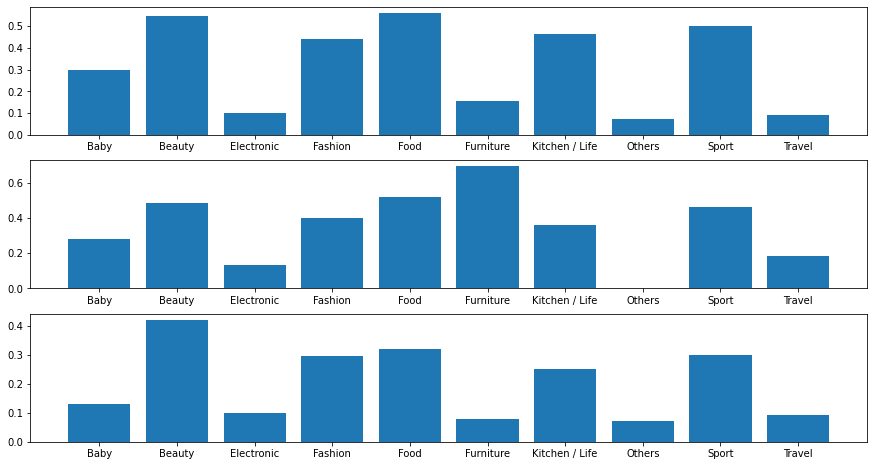

In [313]:
# Cluster 0 
plt.figure(figsize=(15,8))
sum0 = cluster_0[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
plt.subplot(3, 1, 1)
plt.bar(labels, sum0/sum_of_sum)
# Cluster 1 
sum1 = cluster_1[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
plt.subplot(3, 1, 2)
plt.bar(labels, sum1/sum_of_sum)

# Cluster 2
sum2 = cluster_2[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
plt.subplot(3, 1, 3)
plt.bar(labels, sum2/sum_of_sum)

In [314]:
clutering = pd.concat([sum0,sum1,sum2],axis=1)
#clutering = clutering.reindex(['오'])
clutering['labels'] = ['Baby', 'Beauty', 'Electronic', 'Fashion', 'Food', 'Furniture',
       'Kitchen / Life', 'Others', 'Sport', 'Travel']
clutering

,0,1,2,labels
CLAC0_0,16,15,7,Baby
CLAC0_1,17,15,13,Beauty
CLAC0_2,3,4,3,Electronic
CLAC0_3,54,49,36,Fashion
CLAC0_4,14,13,8,Food
CLAC0_5,2,9,1,Furniture
CLAC0_6,13,10,7,Kitchen / Life
CLAC0_7,1,0,1,Others
CLAC0_8,25,23,15,Sport
CLAC0_9,1,2,1,Travel


In [315]:
pd.concat([sum0/sum_of_sum,sum1/sum_of_sum,sum2/sum_of_sum],axis=1)

,0,1,2
CLAC0_0,0.296296,0.277778,0.129630
CLAC0_1,0.548387,0.483871,0.419355
CLAC0_2,0.100000,0.133333,0.100000
CLAC0_3,0.442623,0.401639,0.295082
CLAC0_4,0.560000,0.520000,0.320000
CLAC0_5,0.153846,0.692308,0.076923
CLAC0_6,0.464286,0.357143,0.250000
CLAC0_7,0.071429,0.000000,0.071429
CLAC0_8,0.500000,0.460000,0.300000
CLAC0_9,0.090909,0.181818,0.090909


<BarContainer object of 10 artists>

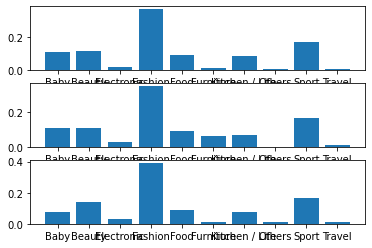

In [316]:
# Cluster 0 
sum0 = cluster_0[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
plt.subplot(3, 1, 1)
plt.bar(labels, sum0/sum0.sum())

# Cluster 1 
sum1 = cluster_1[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
plt.subplot(3, 1, 2)
plt.bar(labels, sum1/sum1.sum())

# Cluster 2
sum2 = cluster_2[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
plt.subplot(3, 1, 3)
plt.bar(labels, sum2/sum2.sum())

In [317]:
def clustering_score(k, new_data, data, transformed_data, category) :
    # k : clustering 개수
    # new_data : new data
    # data : F_20 처럼 m2에서 나이와 성별만 지정한 데이터. 대대분류 포함됨
    # transformed_data : F_20_transformed 처럼 성별과 나이대를 지정하고, predict column이 추가된 transforemd data
    # category : score를 원하는 원하는 대대분류
    
    category_rate = np.empty([k,10])
    
    for i in range(k) :
        idx = np.where(transformed_data['predict']==i)
        clustering = data.loc[data.index[idx]]
        sum_of_sum = np.log(data[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()).sum()
        cate_sum=clustering[['CLAC0_0', 'CLAC0_1', 'CLAC0_2', 'CLAC0_3', 'CLAC0_4', 'CLAC0_5','CLAC0_6', 'CLAC0_7', 'CLAC0_8', 'CLAC0_9']].sum()
        cate_sum[cate_sum== 0] = 1
        category_rate[i] = np.log(cate_sum)/sum_of_sum
        
    diatance_from_centers = [0] * k
    for i in range(k) :
        diatance_from_centers[i] = np.sqrt(sum((km.cluster_centers_[i] - new_data)**2))

    result = [0] * k
    for i in range(k) :
        result[i] = category_rate[i][category]/diatance_from_centers[i]

    return sum(result)

## preprocess

In [318]:
man_cluster

,action_type,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,buy_am,buy_ct,CLAC0_0,CLAC0_1,CLAC0_2,CLAC0_3,...,DVC_PC,DVC_mobile_app,DVC_mobile_web,TRFC_DIRECT,TRFC_PORTAL_1,TRFC_PORTAL_2,TRFC_PORTAL_3,TRFC_PUSH,TRFC_WEBSITE,TRFC_unknown
89,6,155904,11.0,265.0,47880.0,1.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
90,6,155904,11.0,265.0,47880.0,1.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
91,6,470994,24.0,703.0,1059300.0,1.0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
92,7,34263,5.0,115.0,141500.0,1.0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
93,7,38186,5.0,115.0,141500.0,1.0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10473,6,120474,25.0,1577.0,1498000.0,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
10521,6,807097,49.0,835.0,11900.0,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
10545,7,2395956,58.0,2398.0,517770.0,1.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
10661,6,411484,37.0,612.0,46000.0,2.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [319]:
cluster = man_cluster.copy()
cluster['CLNT_ID'] = list(man_cluster.index)
cluster_transformed['CLNT_ID'] = list(man_cluster.index)

In [320]:
cluster_transformed.head()

,action_type,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,buy_am,buy_ct,BIZ_A01,BIZ_A02,BIZ_A03,DVC_PC,...,DVC_mobile_web,TRFC_DIRECT,TRFC_PORTAL_1,TRFC_PORTAL_2,TRFC_PORTAL_3,TRFC_PUSH,TRFC_WEBSITE,TRFC_unknown,predict,CLNT_ID
89,0.0,0.038550,0.049505,0.063035,0.031898,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,89
90,0.0,0.038550,0.049505,0.063035,0.031898,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,90
91,0.0,0.116460,0.113861,0.167222,0.707123,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,91
92,1.0,0.008472,0.019802,0.027355,0.094399,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,92
93,1.0,0.009442,0.019802,0.027355,0.094399,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,93


In [321]:
%%time

cluster['furniture_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,0))
cluster['travel_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,5))
cluster['electronic_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,1))
cluster['pet_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,2))
cluster['sports_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,3))
cluster['food_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,4))
cluster['travel_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,5))
cluster['baby_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,6))
cluster['kitchen_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,7))
cluster['fashion_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,8))
cluster['beauty_SCORE'] = cluster_transformed['CLNT_ID'].apply(lambda x: clustering_score(3, x, cluster, cluster_transformed,9))

CPU times: user 30 s, sys: 3.96 ms, total: 30 s
Wall time: 30 s


In [322]:
transformed_drop = cluster_transformed.drop(['predict', 'CLNT_ID'], axis=1) #,'pd_c'

In [323]:
transformed_drop.head()

,action_type,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,buy_am,buy_ct,BIZ_A01,BIZ_A02,BIZ_A03,DVC_PC,DVC_mobile_app,DVC_mobile_web,TRFC_DIRECT,TRFC_PORTAL_1,TRFC_PORTAL_2,TRFC_PORTAL_3,TRFC_PUSH,TRFC_WEBSITE,TRFC_unknown
89,0.0,0.038550,0.049505,0.063035,0.031898,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90,0.0,0.038550,0.049505,0.063035,0.031898,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
91,0.0,0.116460,0.113861,0.167222,0.707123,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
92,1.0,0.008472,0.019802,0.027355,0.094399,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93,1.0,0.009442,0.019802,0.027355,0.094399,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [324]:
transformed_drop.shape

(378, 19)

In [325]:
score_data = np.empty([transformed_drop.shape[0],10])
for i in tqdm.tqdm(range(len(labels))) :
    for j in range(transformed_drop.shape[0]) : 
        score_data[j,i] = clustering_score(3, transformed_drop.iloc[j], cluster, cluster_transformed, i)*100

100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


In [326]:
score_data = pd.DataFrame(score_data)
score_data.columns = labels
score_data.to_csv('score_M30.csv',index=False)

In [327]:
score_data = pd.read_csv('score_M30.csv')

In [328]:
pd.DataFrame({'min':score_data.min(),'mean':score_data.mean(),'max':score_data.max()})

,min,mean,max
Baby,10.974979,35.409784,97.979146
Beauty,9.685874,26.776679,65.534713
Electronic,9.413207,26.712009,65.438173
Fashion,14.495192,43.415049,109.669997
Food,8.225342,26.177628,70.845801
Furniture,5.971830,17.800006,46.575099
Kitchen / Life,8.424366,17.169275,27.536521
Others,5.742096,15.852660,34.585170
Sport,11.359367,34.142165,90.326526
Travel,3.391200,16.719693,57.601422


In [329]:
CLAC_rate = score_data.div(score_data.sum(axis=1),axis=0)
CLAC_rate.columns = ['C0_Ratio', 'C1_Ratio', 'C2_Ratio', 'C3_Ratio', 'C4_Ratio', 'C5_Ratio', 'C6_Ratio','C7_Ratio', 'C8_Ratio', 'C9_Ratio']
CLAC_rate.index = score_data.index
CLAC_rate.head()

,C0_Ratio,C1_Ratio,C2_Ratio,C3_Ratio,C4_Ratio,C5_Ratio,C6_Ratio,C7_Ratio,C8_Ratio,C9_Ratio
0,0.121954,0.105289,0.108045,0.174010,0.094471,0.065123,0.091367,0.077528,0.122550,0.039665
1,0.121954,0.105289,0.108045,0.174010,0.094471,0.065123,0.091367,0.077528,0.122550,0.039665
2,0.123728,0.106039,0.107468,0.171818,0.094864,0.065945,0.090102,0.073930,0.124560,0.041546
3,0.124435,0.106144,0.107220,0.171183,0.095091,0.066198,0.089245,0.072776,0.125191,0.042517
4,0.124434,0.106144,0.107220,0.171185,0.095090,0.066197,0.089246,0.072778,0.125190,0.042516


In [330]:
CLAC_rate.to_csv('ratio_M30.csv',index=False)

In [331]:
CLAC_rate = pd.read_csv('ratio_M30.csv')
CLAC_rate.head()

,C0_Ratio,C1_Ratio,C2_Ratio,C3_Ratio,C4_Ratio,C5_Ratio,C6_Ratio,C7_Ratio,C8_Ratio,C9_Ratio
0,0.121954,0.105289,0.108045,0.174010,0.094471,0.065123,0.091367,0.077528,0.122550,0.039665
1,0.121954,0.105289,0.108045,0.174010,0.094471,0.065123,0.091367,0.077528,0.122550,0.039665
2,0.123728,0.106039,0.107468,0.171818,0.094864,0.065945,0.090102,0.073930,0.124560,0.041546
3,0.124435,0.106144,0.107220,0.171183,0.095091,0.066198,0.089245,0.072776,0.125191,0.042517
4,0.124434,0.106144,0.107220,0.171185,0.095090,0.066197,0.089246,0.072778,0.125190,0.042516


In [332]:
result_score = CLAC0_data
result_score.index = score_data.index
result_score.head()

,CLAC0_0,CLAC0_1,CLAC0_2,CLAC0_3,CLAC0_4,CLAC0_5,CLAC0_6,CLAC0_7,CLAC0_8,CLAC0_9
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


In [333]:
import tqdm
result_score['furniture_new'] = score_data['Furniture']
for i in tqdm.tqdm(range(len(score_data))) :
    if CLAC_rate['C5_Ratio'][i] > 0.2 :
        result_score['furniture_new'][i] = result_score['furniture_new'][i]*(1 + CLAC_rate['C5_Ratio'][i])

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 378/378 [00:00<00:00, 200258.55it/s]


In [334]:
result_score

,CLAC0_0,CLAC0_1,CLAC0_2,CLAC0_3,CLAC0_4,CLAC0_5,CLAC0_6,CLAC0_7,CLAC0_8,CLAC0_9,furniture_new
0,0,0,0,0,0,0,1,0,0,0,14.756088
1,0,0,0,0,0,0,1,0,0,0,14.756088
2,0,0,1,0,0,0,0,0,0,0,11.127948
3,0,0,0,1,0,0,0,0,0,0,9.637163
4,0,0,0,1,0,0,0,0,0,0,9.638489
...,...,...,...,...,...,...,...,...,...,...,...
373,0,0,0,0,0,1,0,0,0,0,7.611634
374,0,0,0,0,0,0,1,0,0,0,9.991988
375,0,0,0,0,0,0,0,1,0,0,8.885938
376,1,0,0,0,0,0,0,0,0,0,11.250738


In [335]:
pd.DataFrame({'new':result_score['furniture_new'],'orginal':score_data['Furniture'],'ratio':CLAC_rate['C5_Ratio']}).head(10)

,new,orginal,ratio
0,14.756088,14.756088,0.065123
1,14.756088,14.756088,0.065123
2,11.127948,11.127948,0.065945
3,9.637163,9.637163,0.066198
4,9.638489,9.638489,0.066197
5,9.655110,9.655110,0.066192
6,12.685303,12.685303,0.065573
7,15.088976,15.088976,0.065052
8,15.048846,15.048846,0.065060
9,20.059213,20.059213,0.069128


In [336]:
labels

['Baby',
 'Beauty',
 'Electronic',
 'Fashion',
 'Food',
 'Furniture',
 'Kitchen / Life',
 'Others',
 'Sport',
 'Travel']

In [337]:
test = result_score[['furniture_new','CLAC0_5']].sort_values(['furniture_new'],ascending=False)

In [338]:
score_data

,Baby,Beauty,Electronic,Fashion,Food,Furniture,Kitchen / Life,Others,Sport,Travel
0,27.633434,23.857415,24.481749,39.428885,21.406072,14.756088,20.702693,17.566911,27.768493,8.987612
1,27.633434,23.857415,24.481749,39.428885,21.406072,14.756088,20.702693,17.566911,27.768493,8.987612
2,20.878502,17.893471,18.134607,28.993447,16.007874,11.127948,15.204333,12.475352,21.018835,7.010602
3,18.115456,15.452639,15.609191,24.921111,13.843425,9.637163,12.992439,10.594807,18.225480,6.189683
4,18.117921,15.454819,15.611497,24.924886,13.845387,9.638489,12.994446,10.596630,18.227951,6.190402
...,...,...,...,...,...,...,...,...,...,...
373,14.377118,12.092143,12.024434,19.037655,10.837053,7.611634,9.802560,7.676028,14.466670,5.177423
374,18.295411,16.206533,15.544657,23.670173,13.597123,9.991988,14.068307,9.053922,19.056485,5.613711
375,16.676880,14.260085,14.366581,22.882091,12.727829,8.885938,12.020545,9.685725,16.811358,5.659592
376,19.924635,18.783450,17.889641,26.719515,14.919769,11.250738,17.876704,10.632360,21.374178,4.642863


In [339]:
result_score =  pd.DataFrame({'index':list(range(7741))})
result_score.head()

,index
0,0
1,1
2,2
3,3
4,4


In [340]:
result_score['baby_new'] = score_data['Baby']
for i in range(len(score_data)) :
    if CLAC_rate['C0_Ratio'][i] != 0 :
        result_score['baby_new'][i]=score_data['Baby'][i]*(1+CLAC_rate['C0_Ratio'][i])

result_score['beauty_new'] = score_data['Beauty']
for i in range(len(score_data)) :
    if CLAC_rate['C1_Ratio'][i] != 0 :
        result_score['beauty_new'][i]=score_data['Beauty'][i]*(1+CLAC_rate['C1_Ratio'][i])

result_score['electronic_new'] = score_data['Electronic']
for i in range(len(score_data)) :
    if CLAC_rate['C2_Ratio'][i] != 0 :
        result_score['electronic_new'][i]=score_data['Electronic'][i]*(1+CLAC_rate['C2_Ratio'][i])

result_score['fashion_new'] = score_data['Fashion']
for i in range(len(score_data)) :
    if CLAC_rate['C3_Ratio'][i] != 0 :
        result_score['fashion_new'][i]=score_data['Fashion'][i]*(1+CLAC_rate['C3_Ratio'][i])

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [341]:
labels

['Baby',
 'Beauty',
 'Electronic',
 'Fashion',
 'Food',
 'Furniture',
 'Kitchen / Life',
 'Others',
 'Sport',
 'Travel']

In [342]:
result_score['food_new'] = score_data['Food']
for i in tqdm.tqdm(range(len(score_data))) :
    if CLAC_rate['C4_Ratio'][i] != 0 :
        result_score['food_new'][i]=score_data['Food'][i]*(1+CLAC_rate['C4_Ratio'][i])  
        
result_score['furniture_new'] = score_data['Furniture']
for i in tqdm.tqdm(range(len(score_data))) :
    if CLAC_rate['C5_Ratio'][i] != 0 :
        result_score['furniture_new'][i]=score_data['Furniture'][i]*(1+CLAC_rate['C5_Ratio'][i])  
        
result_score['kitchen_new'] = score_data['Kitchen / Life']
for i in tqdm.tqdm(range(len(score_data))) :
    if CLAC_rate['C6_Ratio'][i] != 0 :
        result_score['kitchen_new'][i]=score_data['Kitchen / Life'][i]*(1+CLAC_rate['C6_Ratio'][i])  
        
result_score['others_new'] = score_data['Others']
for i in tqdm.tqdm(range(len(score_data))) :
    if CLAC_rate['C7_Ratio'][i] != 0 :
        result_score['others_new'][i]=score_data['Others'][i]*(1+CLAC_rate['C7_Ratio'][i])  
        
result_score['sport_new'] = score_data['Sport']
for i in tqdm.tqdm(range(len(score_data))) :
    if CLAC_rate['C8_Ratio'][i] != 0 :
        result_score['sport_new'][i]=score_data['Sport'][i]*(1+CLAC_rate['C8_Ratio'][i])  
        
result_score['travel_new'] = score_data['Travel']
for i in tqdm.tqdm(range(len(score_data))) :
    if CLAC_rate['C9_Ratio'][i] != 0 :
         result_score['travel_new'][i]=score_data['Travel'][i]*(1+CLAC_rate['C9_Ratio'][i])

  0%|          | 0/378 [00:00<?, ?it/s]/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
  0%|          | 0/378 [00:00<?, ?it/s]/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
  0%|          | 0/378 [00:00<?, ?it/s]/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [343]:
result_score.isna().sum()

index                0
baby_new          7363
beauty_new        7363
electronic_new    7363
fashion_new       7363
food_new          7363
furniture_new     7363
kitchen_new       7363
others_new        7363
sport_new         7363
travel_new        7363
dtype: int64

In [344]:
result_score.drop(['index'],axis=1).head()

,baby_new,beauty_new,electronic_new,fashion_new,food_new,furniture_new,kitchen_new,others_new,sport_new,travel_new
0,31.003437,26.369344,27.126869,46.289918,23.428320,15.717042,22.594227,18.928830,31.171518,9.344103
1,31.003437,26.369344,27.126869,46.289918,23.428320,15.717042,22.594227,18.928830,31.171518,9.344103
2,23.461760,19.790869,20.083489,33.975048,17.526450,11.861785,16.574281,13.397657,23.636936,7.301861
3,20.369657,17.092849,17.282803,29.187190,15.159805,10.275121,14.151951,11.365853,20.507146,6.452849
4,20.372410,17.095255,17.285362,29.191641,15.161950,10.276531,14.154149,11.367830,20.509906,6.453592


In [345]:
result_score.to_csv('final_score_M50.csv',index=False)

In [346]:
result_score = pd.read_csv('final_score_M50.csv')
result_score.head()

,index,baby_new,beauty_new,electronic_new,fashion_new,food_new,furniture_new,kitchen_new,others_new,sport_new,travel_new
0,0,31.003437,26.369344,27.126869,46.289918,23.428320,15.717042,22.594227,18.928830,31.171518,9.344103
1,1,31.003437,26.369344,27.126869,46.289918,23.428320,15.717042,22.594227,18.928830,31.171518,9.344103
2,2,23.461760,19.790869,20.083489,33.975048,17.526450,11.861785,16.574281,13.397657,23.636936,7.301861
3,3,20.369657,17.092849,17.282803,29.187190,15.159805,10.275121,14.151951,11.365853,20.507146,6.452849
4,4,20.372410,17.095255,17.285362,29.191641,15.161950,10.276531,14.154149,11.367830,20.509906,6.453592


In [347]:
result_score.drop('index',axis=1,inplace=True)

In [353]:
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles,[angles[0]]))

mean_stats = result_score.mean().values
mean_stats = np.concatenate((mean_stats,[mean_stats[0]]))

In [378]:
result_score.dropna()

,baby_new,beauty_new,electronic_new,fashion_new,food_new,furniture_new,kitchen_new,others_new,sport_new,travel_new
0,31.003437,26.369344,27.126869,46.289918,23.428320,15.717042,22.594227,18.928830,31.171518,9.344103
1,31.003437,26.369344,27.126869,46.289918,23.428320,15.717042,22.594227,18.928830,31.171518,9.344103
2,23.461760,19.790869,20.083489,33.975048,17.526450,11.861785,16.574281,13.397657,23.636936,7.301861
3,20.369657,17.092849,17.282803,29.187190,15.159805,10.275121,14.151951,11.365853,20.507146,6.452849
4,20.372410,17.095255,17.285362,29.191641,15.161950,10.276531,14.154149,11.367830,20.509906,6.453592
...,...,...,...,...,...,...,...,...,...,...
373,16.204674,13.384949,13.302803,22.242108,11.875417,8.123885,10.652143,8.196982,16.317063,5.414426
374,20.602274,18.016697,17.209986,27.531535,14.871306,10.680072,15.432329,9.618873,21.559268,5.830900
375,18.752751,15.777888,15.907138,26.790162,13.936978,9.475294,13.099043,10.385946,18.920844,5.898670
376,22.345108,20.934598,19.840935,31.072394,16.276968,12.022496,19.825176,11.321613,24.159647,4.774292


<br><br>
### 선호도 결과 시각화
첫 번째 그림은 A03을 제거한 결과이고,  
두 번째 그림은 모두 포함한 결과입니다.  
보이는 것과 같이 단순히 A03을 제거하는 것만으로도 Food의 영향도가 현저히 줄어들었습니다. 

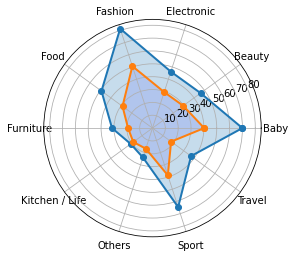

In [376]:
stats = result_score.iloc[50].values
stats = np.concatenate((stats,[stats[0]]))

fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles[:10] * 180/np.pi, labels)
ax.plot(angles, mean_stats, 'o-', linewidth=2)
ax.fill(angles, mean_stats,"b",alpha=0.1)

ax.grid(True)

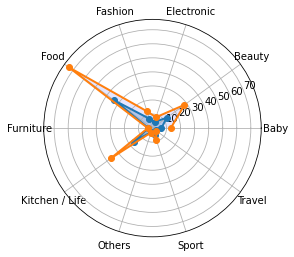

In [169]:
tats = result_score.iloc[30].values
# stats = np.concatenate((stats,[stats[0]]))

fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.plot(angles, mean_stats, 'o-', linewidth=2)
ax.fill(angles, mean_stats,"b",alpha=0.1)

ax.grid(True)